In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import plot
plot.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/")

In [2]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.plt.rcParams['text.usetex'] = True
# plot.plt.rcParams['font.family'] = 'serif'
plot.plt.rcParams['font.serif'] = 'Times Roman'
# plot.FORMAT_X = 1
# plot.FORMAT_Y = 3
plot.dict_key_to_label.update(
    {
        "ROUGE_L": "rouge score",
        "Bleu_1": "bleu1 score",
        "Bleu_4": "bleu4 score",
        "METEOR": "meteor score",
        "CIDEr": "cider score"        
    }
)
do_save = True


In [3]:
from captioning import fts_bleu4, fts_bleu, fts_rouge, fts_meteor, fts_bleurouge, fts_bleumeteor, fts_bleubleu4, fts_rougebleu4, fts_cider, fts_ciderbleu, fts_rougecider
from captioning import e2e_bleu, e2e_bleu4, e2e_rouge, e2e_bleurouge, e2e_bleu4rouge, e2e_meteor, e2e_bleubleu4, e2e_bleumeteor, e2e_cider

In [4]:
do_save=False
def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise ValueError()
arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1)

In [5]:
def plot_captioning(list_l, key_x, key_y, loc="lower left", _dict_key_to_limit={}):
    dict_key_to_label = {
        "ROUGE_L": "rouge",
        "Bleu_1": "bleu1",
        "Bleu_4": "bleu4",
        "METEOR": "meteor",
        "CIDEr": "cider"
    }
    label_x = dict_key_to_label[key_x]
    label_y = dict_key_to_label[key_y]
    label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
    labels = [
        r"RL: ${label_x}$ reward".format(label_x=label_x
                                        ), r"WA: $init \to {label_x}$".format(label_x=label_x),
        r"RL: ${label_y}$ reward".format(label_y=label_y),
        r"WA: $init \to {label_y}$".format(label_y=label_y),
        r"RL: $\frac{{{label_xy}}}{{2}}$ reward".format(label_xy=label_xy),
        r"WA: ${label_x} \to {label_y}$".format(label_x=label_x, label_y=label_y)
    ]
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        labels=labels,
        loc=loc,
        # keycolor="lambda",
        colormaps=['Blues', 'Blues', 'Reds', 'Reds', "Greens", 'Greens'],
        linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
        order="savgol_3_1_quadratic",
        _dict_key_to_limit=_dict_key_to_limit,
    )
    plot.plt.annotate(
        "pre-trained init",
        xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    plot.plt.annotate(
        r"${label_x}$".format(label_x=label_x) + "\nrewarded",
        xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
        ha='right',
        va="bottom",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    plot.plt.annotate(
        r"${label_y}$".format(label_y=label_y) + "\nrewarded",
        xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )

    plot.plt.annotate(
        r"$\lambda=0.5$",
        xy=(
            get_at_coeff(list_l[5])[key_x],
            get_at_coeff(list_l[5])[key_y]
        ),
        ha='left',
        va="bottom",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    return fig_dr

# bleu to bleu4

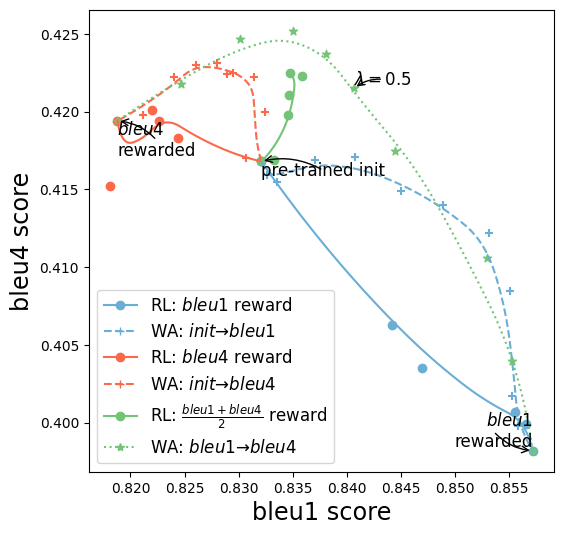

In [6]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_bleubleu4.l_step,
        e2e_bleubleu4.l_wa_bleu4bleu
    ],
    key_x="Bleu_1",
    key_y="Bleu_4"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutobleu4.pdf", do_save=do_save)


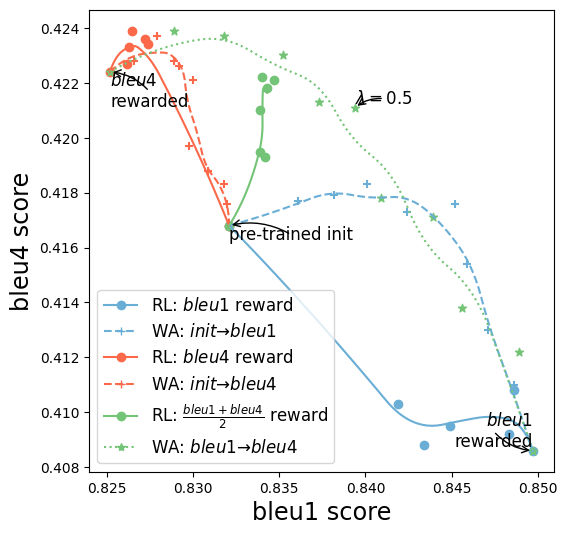

In [10]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step, fts_bleu.l_wa, fts_bleu4.l_step, fts_bleu4.l_wa, fts_bleubleu4.l_step,
        fts_bleubleu4.l_wa
    ],
    key_x="Bleu_1",
    key_y="Bleu_4"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutobleu4.pdf", do_save=do_save)


# bleu to meteor

In [ ]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_meteor.l_step, e2e_meteor.l_wa, e2e_bleumeteor.l_step,
        e2e_bleumeteor.l_wa_meteorbleu
    ],
    key_x="Bleu_1",
    key_y="METEOR"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutometeor.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step,
        fts_bleu.l_wa,
        fts_meteor.l_step,
        fts_meteor.l_wa,
        fts_bleumeteor.l_step,
        fts_bleumeteor.l_wa,
    ],
    key_x="Bleu_1",
    key_y="METEOR"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutometeor.pdf", do_save=do_save)

# Bleu to ROUGE

In [ ]:
fig_dr = plot_captioning(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleurouge.l_step_rougebleu, e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutorouge.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_wa, fts_rouge.l_step, fts_rouge.l_wa_step5,
        fts_bleurouge.l_step, fts_bleurouge.l_wa_epoch5
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutorouge.pdf", do_save=do_save)

# bleu4 to rouge

In [ ]:
fig_dr = plot_captioning(
    [
        fts_bleu4.l_step,
        fts_bleu4.l_wa,
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_rougebleu4.l_step,
        fts_rougebleu4.l_wa,
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    loc="upper left",
    _dict_key_to_limit={"Bleu_4": [0.413,0.425]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu4torouge.pdf", do_save=do_save)

In [ ]:
fig_dr = plot_captioning(
    [
        e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa, e2e_bleu4rouge.l_step,
        e2e_bleu4rouge.l_wa
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    loc="upper left",
    _dict_key_to_limit={"Bleu_4": [0.413, 0.425], "ROUGE_L": [0.6045, 0.611]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu4torouge.pdf", do_save=do_save)

# CIDER

In [ ]:
# [
#     fts_bleu.l_step,
#     fts_bleu.l_wa,
#     fts_cider.l_step,
#     fts_cider.l_wa,
#     e2e_cider.l_step,
#     fts_ciderbleu.l_step,
#     fts_ciderbleu.l_wa,
#     fts_rougecider.l_wa
# ],

In [ ]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_wa, fts_cider.l_step, fts_cider.l_wa, 
        fts_ciderbleu.l_step, fts_ciderbleu.l_wa,
    ],
    key_x="Bleu_1",
    key_y="CIDEr",
    loc="lower left"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tocider.pdf", do_save=do_save)

# Bleu rouge enriched

In [11]:
def plot_captioning_enriched(list_l, labels, colormaps, linestyles, key_x, key_y, loc="lower left", **kwargs):
    dict_key_to_label = {
        "ROUGE_L": "rouge",
        "Bleu_1": "bleu1",
        "Bleu_4": "bleu4",
        "METEOR": "meteor",
        "CIDEr": "cider"
    }
    label_x = dict_key_to_label[key_x]
    label_y = dict_key_to_label[key_y]
    label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        labels=labels,
        loc=loc,
        colormaps=colormaps,
        linestyles=linestyles,
        order="connect",
        **kwargs,
    )
    plot.plt.annotate(
        "pre-trained init",
        xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    plot.plt.annotate(
        r"${label_x}$".format(label_x=label_x) + "\nrewarded",
        xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
        ha='right',
        va="bottom",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    plot.plt.annotate(
        r"${label_y}$".format(label_y=label_y) + "\nrewarded",
        xy=(list_l[3][-1][key_x], list_l[3][-1][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )

    plot.plt.annotate(
        r"$\lambda=0.5$",
        xy=(get_at_coeff(list_l[5])[key_x], get_at_coeff(list_l[5])[key_y]),
        ha='left',
        va="bottom",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    return fig_dr

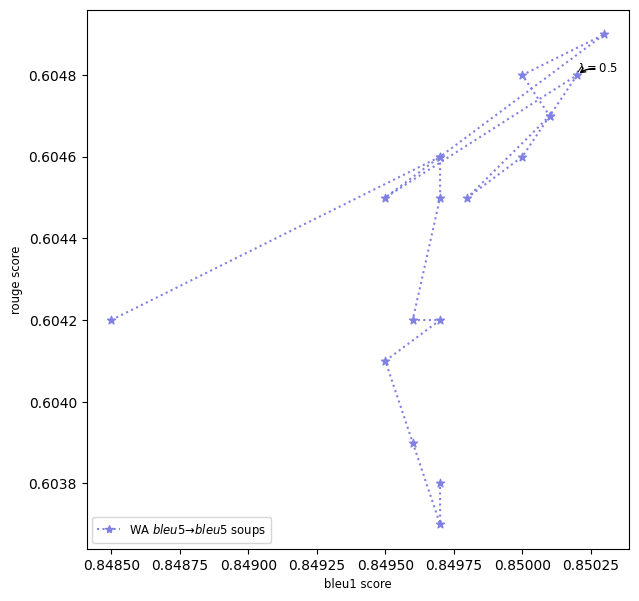

In [12]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"

fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step_epoch10, fts_bleu.l_stepv2, fts_bleu.l_wa, fts_bleu.l_wa_epochx,
        fts_bleu.l_wa_step5to10, fts_bleu.l_soup, fts_rouge.l_step_epoch10, fts_rouge.l_stepv2,
        fts_rouge.l_wa_step5, fts_rouge.l_wa_step5to10, fts_bleurouge.l_step,
        fts_bleurouge.l_step_15, fts_bleurouge.l_step_51, fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_epoch10, fts_bleurouge.l_wa_bleu_multi, fts_bleurouge.l_wa_rouge_multi,
        fts_bleurouge.l_ens, fts_bleurouge.l_ens_step10
    ],
    # list_indexes = [5],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"RL $bleu$ reward",
        r"RL $bleu$ reward v2",
        r"WA $init \to bleu$ epoch 5",
        r"WA $init \to bleu$ epoch x",
        r"WA $bleu5 \to bleu10$",
        r"WA $bleu5 \to bleu5$ soups",
        r"RL $rouge$ reward",
        r"RL $rouge$ reward v2",
        r"WA $init \to rouge$",
        r"WA $rouge5 \to rouge10$",
        r"RL $bleu+rouge$ reward",
        r"RL $bleu+0.5 \times rouge$ reward",
        r"RL $0.5 \times bleu+ rouge$ reward",
        r"WA $rouge \to bleu$ epoch 5",
        r"WA $rouge \to bleu$ epoch 10",
        r"WA $bleu \to multi$ epoch 5",
        r"WA $rouge \to multi$ epoch 5",
        r"ENS $rouge \to bleu$ epoch 5",
        r"ENS $rouge \to bleu$ epoch 10",
    ],
    colormaps=[
        "Blues", "Blues", "Blues", "Blues", "Blues", "Dark_Blues", "Reds", "Reds", "Reds",
        "Purples", "Greens", "Greens", "Greens", "Greens", "Greens", "Greys", "Greys", "Yellows",
        "Yellows"
    ],
    linestyles=[
        "solid", "solid", "dashed", "dashed", "dotted", "dotted", "solid", "solid", "dashed",
        "dashed", "solid", "solid", "solid", "dotted", "dashdot", "dashdot", "dashed", "dashed",
        "solid", "dashed"
    ],
    _dict_key_to_limit={
        # "Bleu_1": [0.78, 0.86],
        # "ROUGE_L": [0.609, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutorouge_enriched.pdf", do_save=do_save)